<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo sequence to sequence - Traductor

### Consigna

Replicar y extender el traductor:
- Replicar el modelo en PyTorch.
- Extender el entrenamiento a más datos y tamaños de secuencias mayores.
- Explorar el impacto de la cantidad de neuronas en las capas recurrentes.
- Mostrar 5 ejemplos de traducciones generadas.

Extras que se pueden probar: 
- Embeddingspre-entrenados para los dos idiomas
- Cambiar la estrategia de generación (por ejemplo muestreo aleatorio)

## 1. Datos

In [28]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
from torchinfo import summary

import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [30]:
# Descargar la carpeta de dataset
import gdown
import zipfile
if os.access('spa-eng', os.F_OK) is False:
    if os.access('simpsons_dataset.zip', os.F_OK) is False:
        url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
        output = os.path.join("./Dataset", "spa-eng.zip")
        gdown.download(url, output, quiet=False)
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall("./Dataset")
else:
    print("El dataset ya se encuentra descargado")

# dataset_file

text_file = os.path.join("./Dataset", "spa-eng/spa.txt")
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]


Downloading...
From: http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
To: /home/agustin/Desktop/CEIA UBA/Procesamiento Lenguaje Natural I/CEIA-ProcesamientoLenguajeNaturalI/Desafio_4/Dataset/spa-eng.zip
100%|██████████| 2.64M/2.64M [00:04<00:00, 618kB/s]


## 2. Entrenamiento Baseline
Se tomará el modelo entrenado en clase como Baseline para comparación al aplicar cambios:

### 2.1. Limitación dataset

In [31]:
# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

def generar_secuencias(lines, MAX_NUM_SENTENCES=6000):
    input_sentences = []
    output_sentences = []
    output_sentences_inputs = []
    count = 0

    for line in lines:
        count += 1
        if count > MAX_NUM_SENTENCES:
            break

        if '\t' not in line:
            continue

        # Input sentence --> eng
        # output --> spa
        input_sentence, output = line.rstrip().split('\t')

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)
    return input_sentences, output_sentences, output_sentences_inputs


# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 6000
input_sentences, output_sentences, output_sentences_inputs = generar_secuencias(lines, MAX_NUM_SENTENCES)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 6000


In [32]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

### 2.2. Preprocesamiento

In [33]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from torch_helpers import Tokenizer

def tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE=8000):
    input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
    input_tokenizer.fit_on_texts(input_sentences)
    input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

    word2idx_inputs = input_tokenizer.word_index
    print("Palabras en el vocabulario:", len(word2idx_inputs))

    max_input_len = max(len(sen) for sen in input_integer_seq)
    print("Sentencia de entrada más larga:", max_input_len)


    # A los filtros de símbolos del Tokenizer agregamos el "¿",
    # sacamos los "<>" para que no afectar nuestros tokens
    output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
    output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
    output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
    output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

    word2idx_outputs = output_tokenizer.word_index
    print("Palabras en el vocabulario:", len(word2idx_outputs))

    num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
    max_out_len = max(len(sen) for sen in output_integer_seq)
    print("Sentencia de salida más larga:", max_out_len)

    return {
        'input_tokenizer': input_tokenizer,
        'output_tokenizer': output_tokenizer,
        'input_integer_seq': input_integer_seq,
        'output_integer_seq': output_integer_seq,
        'output_input_integer_seq': output_input_integer_seq,
        'word2idx_inputs': word2idx_inputs,
        'word2idx_outputs': word2idx_outputs,
        'max_input_len': max_input_len,
        'max_out_len': max_out_len,
        'num_words_output': num_words_output
    }

# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

salida_tokenizador = tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE)

input_tokenizer = salida_tokenizador["input_tokenizer"]
output_tokenizer = salida_tokenizador["output_tokenizer"]
input_integer_seq = salida_tokenizador["input_integer_seq"]
output_integer_seq = salida_tokenizador["output_integer_seq"]
output_input_integer_seq = salida_tokenizador["output_input_integer_seq"]
num_words_output = salida_tokenizador["num_words_output"]
word2idx_inputs = salida_tokenizador["word2idx_inputs"]
word2idx_outputs = salida_tokenizador["word2idx_outputs"]


Palabras en el vocabulario: 3851
Sentencia de entrada más larga: 32
Palabras en el vocabulario: 5721
Sentencia de salida más larga: 36


In [34]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 16
max_out_len = 18

In [35]:
from torch_helpers import pad_sequences
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

Cantidad de rows del dataset: 6000
encoder_input_sequences shape: (6000, 16)
decoder_input_sequences shape: (6000, 18)
decoder_output_sequences shape: (6000, 18)


In [36]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.decoder_outputs = F.one_hot(torch.from_numpy(decoder_output).to(torch.int64), num_classes=num_words_output).float()

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self,index):
        return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

    def __len__(self):
        return self.len

data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = data_set.decoder_outputs.shape[2]
print("Output dim", output_dim)

encoder_input_size: 16
decoder_input_size: 18
Output dim 5722


In [37]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

Tamaño del conjunto de entrenamiento: 4800
Tamaño del conjunto de validacion: 1200


### 2.3. Preparar los embeddings

In [38]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [39]:
import logging
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [40]:
# Por una cuestion de RAM se utilizará los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [41]:
# Crear la Embedding matrix de las secuencias
# en ingles


def preparar_embedding_matrix(model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE):
    embed_dim = model_embeddings.N_FEATURES
    words_not_found = []

    # word_index provieen del tokenizer

    nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
    embedding_matrix = np.zeros((nb_words, embed_dim))
    for word, i in word2idx_inputs.items():
        if i >= nb_words:
            continue
        embedding_vector = model_embeddings.get_words_embeddings(word)[0]
        if (embedding_vector is not None) and len(embedding_vector) > 0:
            
            embedding_matrix[i] = embedding_vector
        else:
            # words not found in embedding index will be all-zeros.
            words_not_found.append(word)

    print('Número de embeddings nulos:', np.sum(np.sum(embedding_matrix, axis=1) == 0))
    return embedding_matrix, words_not_found, nb_words

embedding_matrix, words_not_found, nb_words = preparar_embedding_matrix(model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE)

Número de embeddings nulos: 30


In [42]:
nb_words

3851

In [43]:
# Dimensión de los embeddings de la secuencia en ingles
embedding_matrix.shape

(3851, 50)

### 2.4. Entrenar modelo

In [44]:
from tqdm import tqdm

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_matrix):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)

        # Para utilizar versión con embedding preentrenados
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # 

        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        # tensor para almacenar la salida
        # (batch_size, sentence_len, one_hot_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)
        
        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
      
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing", es decir que durante
            # el entrenamiento no realimentamos la salida del decoder
            # sino el token correcto que sigue en target
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # Sino se usará "teacher forcing" habría que descomentar
            # esta linea.
            # Hay ejemplos dandos vuelta en donde se utilza un random 
            # para ver en cada vuelta que técnica se aplica
            #input = top1            

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs

encoder = Encoder(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica


### CORREGIR ERROR
#summary(model, input_data=(data_set[0:1][0], data_set[0:1][1]))

In [45]:
from tqdm import tqdm

def sequence_acc(y_pred, y_test):
    y_pred_tag = y_pred.data.max(dim=-1,keepdim=True)[1]
    y_test_tag = y_test.data.max(dim=-1,keepdim=True)[1]

    batch_size = y_pred_tag.shape[0]
    batch_acc = torch.zeros(batch_size)
    for b in range(batch_size):
        correct_results_sum = (y_pred_tag[b] == y_test_tag[b]).sum().float()
        batch_acc[b] = correct_results_sum / y_pred_tag[b].shape[0]

    correct_results_sum = batch_acc.sum().float()
    acc = correct_results_sum / batch_size
    return acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        # tqdm para los batches de entrenamiento
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for train_encoder_input, train_decoder_input, train_target in loop:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_encoder_input.to(device), train_decoder_input.to(device))

            # Computo el error de la salida comparando contra las etiquetas
            # por cada token en cada batch (sequence_loss)
            loss = 0
            for t in range(train_decoder_input.shape[1]):
                loss += criterion(output[:, t, :], train_target[:, t, :])

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = sequence_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_encoder_input, valid_decoder_input, valid_target = next(iter(valid_loader))
        output = model(valid_encoder_input.to(device), valid_decoder_input.to(device))
        
        epoch_valid_loss = 0
        for t in range(train_decoder_input.shape[1]):
                epoch_valid_loss += criterion(output[:, t, :], valid_target[:, t, :])
        epoch_valid_loss = epoch_valid_loss.item()

        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = sequence_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

In [46]:
history1 = train(model,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=10
                )

Epoch: 1/10 - Train loss 144.850 - Train accuracy 0.606 - Valid Loss 144.899 - Valid accuracy 0.602


Epoch: 2/10 - Train loss 144.754 - Train accuracy 0.610 - Valid Loss 144.899 - Valid accuracy 0.602


Epoch: 3/10 - Train loss 144.754 - Train accuracy 0.611 - Valid Loss 144.899 - Valid accuracy 0.602


Epoch: 4/10 - Train loss 144.751 - Train accuracy 0.611 - Valid Loss 144.899 - Valid accuracy 0.602


Epoch: 5/10 - Train loss 144.738 - Train accuracy 0.611 - Valid Loss 144.836 - Valid accuracy 0.606


Epoch: 6/10 - Train loss 144.321 - Train accuracy 0.635 - Valid Loss 144.245 - Valid accuracy 0.639


Epoch: 7/10 - Train loss 143.915 - Train accuracy 0.657 - Valid Loss 144.033 - Valid accuracy 0.651


Epoch: 8/10 - Train loss 143.822 - Train accuracy 0.662 - Valid Loss 144.086 - Valid accuracy 0.648


Epoch: 9/10 - Train loss 143.777 - Train accuracy 0.665 - Valid Loss 143.955 - Valid accuracy 0.655


Epoch: 10/10 - Train loss 143.759 - Train accuracy 0.666 - Valid Loss 143.904 - Valid accuracy 0.658


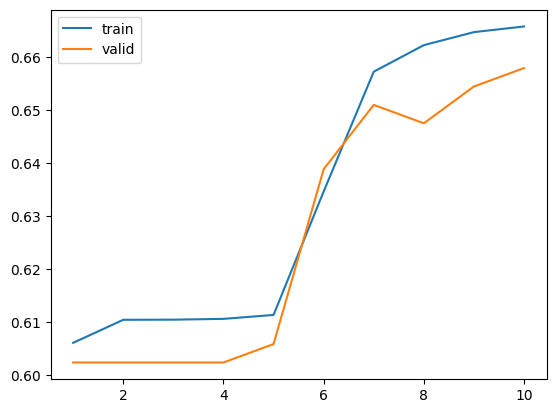

In [47]:
def graficar_accuracy(history):
    epoch_count = range(1, len(history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
    plt.show()

graficar_accuracy(history1)

### 2.5. Inferencia

In [48]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [49]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

# Se obtiene la salida del encoder (el estado oculto para el decoder)
prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

# Se inicializa la secuencia de entrada al decoder como "<sos>"
target_seq = np.zeros((1, 1))
target_seq[0, 0] = word2idx_outputs['<sos>']
target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

# Se obtiene la primera palabra de la secuencia de salida del decoder
output, prev_state = model.decoder(target_seq_tensor.to(device), prev_state)

top1 = output.argmax(1).view(-1, 1)
idx = int(top1.cpu())
print("Index/token de salida:", idx)

word = idx2word_target[idx]
print("Palabra de salida:", word)

Input: My mother say hi.
Representacion en vector de tokens de ids [15, 225, 134]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0  15 225 134]]
Index/token de salida: 6
Palabra de salida: tom


In [50]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output, new_prev_state = model.decoder(target_seq_tensor.to(device), prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu())

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar ídx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        prev_state = new_prev_state

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq_tensor = top1

    return ' '.join(output_sentence)

In [51]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: My mother say hi.
Representacion en vector de tokens de ids [15, 225, 134]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0  15 225 134]]
Response: tom que


In [52]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
translation = translate_sentence(encoder_sequence_test_tensor)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: Mary wants to buy a dress.
Response: tom que


## 3. Aumentar tamaño dataset entrenamiento
Duplicamos el tamaño del dataset de entrenamiento a 12 líneas

In [53]:
MAX_NUM_SENTENCES = 12000
input_sentences, output_sentences, output_sentences_inputs = generar_secuencias(lines, MAX_NUM_SENTENCES)


salida_tokenizador = tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE)

input_tokenizer = salida_tokenizador["input_tokenizer"]
output_tokenizer = salida_tokenizador["output_tokenizer"]
input_integer_seq = salida_tokenizador["input_integer_seq"]
output_integer_seq = salida_tokenizador["output_integer_seq"]
output_input_integer_seq = salida_tokenizador["output_input_integer_seq"]
num_words_output = salida_tokenizador["num_words_output"]
word2idx_inputs = salida_tokenizador["word2idx_inputs"]
word2idx_outputs = salida_tokenizador["word2idx_outputs"]


encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)



Palabras en el vocabulario: 5409
Sentencia de entrada más larga: 32
Palabras en el vocabulario: 8584
Sentencia de salida más larga: 36


In [54]:
embedding_matrix, words_not_found, nb_words = preparar_embedding_matrix(model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE)

encoder = Encoder(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

history_2 = train(model,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=10
                )



Número de embeddings nulos: 53


Epoch: 1/10 - Train loss 150.890 - Train accuracy 0.606 - Valid Loss 150.798 - Valid accuracy 0.609


Epoch: 2/10 - Train loss 149.993 - Train accuracy 0.655 - Valid Loss 150.024 - Valid accuracy 0.653


Epoch: 3/10 - Train loss 149.854 - Train accuracy 0.662 - Valid Loss 150.029 - Valid accuracy 0.653


Epoch: 4/10 - Train loss 149.834 - Train accuracy 0.663 - Valid Loss 150.023 - Valid accuracy 0.653


Epoch: 5/10 - Train loss 149.832 - Train accuracy 0.663 - Valid Loss 150.055 - Valid accuracy 0.651


Epoch: 6/10 - Train loss 149.829 - Train accuracy 0.664 - Valid Loss 150.114 - Valid accuracy 0.648


Epoch: 7/10 - Train loss 149.827 - Train accuracy 0.664 - Valid Loss 150.023 - Valid accuracy 0.653


Epoch: 8/10 - Train loss 149.829 - Train accuracy 0.664 - Valid Loss 150.050 - Valid accuracy 0.651


Epoch: 9/10 - Train loss 149.822 - Train accuracy 0.664 - Valid Loss 150.055 - Valid accuracy 0.651


Epoch: 10/10 - Train loss 149.826 - Train accuracy 0.664 - Valid Loss 150.052 - Valid accuracy 0.651


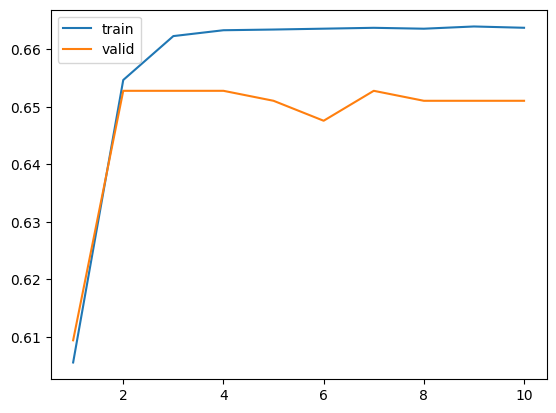

In [58]:
graficar_accuracy(history_2)

## 4. Aumentar tamaño de las secuencias
Aumentamos el tamaño de input maximo a 25 (la más larga en el dataset es 32) y del output a 30 (la más larga en el dataset es 36)

In [55]:
MAX_NUM_SENTENCES = 6000
max_input_len = 25
max_out_len = 30

input_sentences, output_sentences, output_sentences_inputs = generar_secuencias(lines, MAX_NUM_SENTENCES)


salida_tokenizador = tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE)

input_tokenizer = salida_tokenizador["input_tokenizer"]
output_tokenizer = salida_tokenizador["output_tokenizer"]
input_integer_seq = salida_tokenizador["input_integer_seq"]
output_integer_seq = salida_tokenizador["output_integer_seq"]
output_input_integer_seq = salida_tokenizador["output_input_integer_seq"]
num_words_output = salida_tokenizador["num_words_output"]
word2idx_inputs = salida_tokenizador["word2idx_inputs"]
word2idx_outputs = salida_tokenizador["word2idx_outputs"]


encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

Palabras en el vocabulario: 3851
Sentencia de entrada más larga: 32
Palabras en el vocabulario: 5721
Sentencia de salida más larga: 36


In [56]:
embedding_matrix, words_not_found, nb_words = preparar_embedding_matrix(model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE)

encoder = Encoder(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

history_3 = train(model,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=10
                )



Número de embeddings nulos: 30


Epoch: 1/10 - Train loss 236.752 - Train accuracy 0.762 - Valid Loss 236.152 - Valid accuracy 0.781


Epoch: 2/10 - Train loss 235.654 - Train accuracy 0.797 - Valid Loss 235.710 - Valid accuracy 0.796


Epoch: 3/10 - Train loss 235.559 - Train accuracy 0.800 - Valid Loss 235.775 - Valid accuracy 0.793


Epoch: 4/10 - Train loss 235.554 - Train accuracy 0.801 - Valid Loss 235.853 - Valid accuracy 0.791


Epoch: 5/10 - Train loss 235.571 - Train accuracy 0.800 - Valid Loss 235.790 - Valid accuracy 0.793


Epoch: 6/10 - Train loss 235.567 - Train accuracy 0.800 - Valid Loss 235.721 - Valid accuracy 0.795


Epoch: 7/10 - Train loss 235.562 - Train accuracy 0.800 - Valid Loss 235.811 - Valid accuracy 0.792


Epoch: 8/10 - Train loss 235.586 - Train accuracy 0.800 - Valid Loss 235.773 - Valid accuracy 0.794


Epoch: 9/10 - Train loss 235.608 - Train accuracy 0.799 - Valid Loss 235.837 - Valid accuracy 0.792


Epoch: 10/10 - Train loss 235.598 - Train accuracy 0.799 - Valid Loss 235.940 - Valid accuracy 0.787


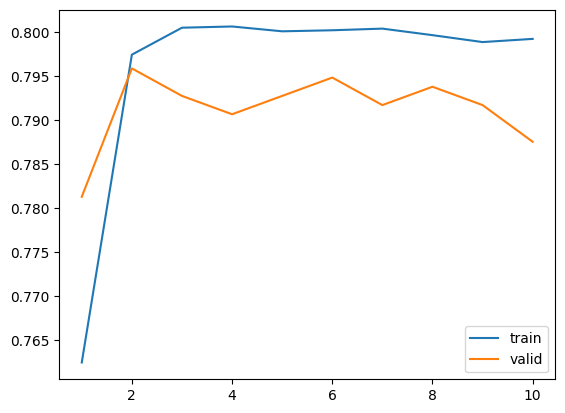

In [59]:
graficar_accuracy(history_3)